In [ ]:
import tensorflow as tf
import os

# Constants
IMAGE_SIZE = 128
BATCH_SIZE = 16
BUFFER_SIZE = 1000
SPLIT_RATIO = {"train": 0.8, "val": 0.1, "test": 0.1}

# Load and augment images
def load_image(image_path, image_size=IMAGE_SIZE):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [image_size, image_size])
    image = (image / 127.5) - 1.0
    return image

def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

def load_image_pair(conditonal_path, derge_path, augment=False):
    conditonal_image = load_image(conditonal_path)
    derge_image = load_image(derge_path)
    if augment:
        conditonal_image = augment_image(conditonal_image)
        derge_image = augment_image(derge_image)
    return conditonal_image, derge_image

def prepare_dataset(conditonal_dir, derge_dir, augment=False):
    conditonal_image_paths = sorted([os.path.join(conditonal_dir, fname) for fname in os.listdir(conditonal_dir)])
    derge_image_paths = sorted([os.path.join(derge_dir, fname) for fname in os.listdir(derge_dir)])
    
    dataset = tf.data.Dataset.from_tensor_slices((conditonal_image_paths, derge_image_paths))
    dataset = dataset.map(lambda x, y: load_image_pair(x, y, augment), num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    total_size = len(conditonal_image_paths)
    train_size = int(SPLIT_RATIO["train"] * total_size)
    val_size = int(SPLIT_RATIO["val"] * total_size)
    
    train_dataset = dataset.take(train_size // BATCH_SIZE)
    remaining_dataset = dataset.skip(train_size // BATCH_SIZE)
    
    val_dataset = remaining_dataset.take(val_size // BATCH_SIZE)
    test_dataset = remaining_dataset.skip(val_size // BATCH_SIZE)
    
    return train_dataset, val_dataset, test_dataset


2024-09-18 08:20:37.715935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 08:20:37.736812: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 08:20:37.743203: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-18 08:20:37.759385: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 08:20:40.501077: I tensorflow/core/common_

Train Dataset - Conditional Image Batch Shape: (16, 128, 128, 1)
Train Dataset - Derge Image Batch Shape: (16, 128, 128, 1)


2024-09-18 08:20:41.112049: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Dataset - Conditional Image Batch Shape: (16, 128, 128, 1)
Validation Dataset - Derge Image Batch Shape: (16, 128, 128, 1)


2024-09-18 08:20:42.032764: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Test Dataset - Conditional Image Batch Shape: (16, 128, 128, 1)
Test Dataset - Derge Image Batch Shape: (16, 128, 128, 1)


In [4]:
import tensorflow as tf
from tensorflow.keras import layers

def build_generator():
    """Builds the generator model to map a Monlam glyph image to a Derge glyph image."""
    
    # Input: Monlam glyph image
    inputs = layers.Input(shape=(128, 128, 1))
    
    # Encoder
    down1 = layers.Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    down1 = layers.LeakyReLU()(down1)
    
    down2 = layers.Conv2D(128, (4, 4), strides=2, padding='same')(down1)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.LeakyReLU()(down2)
    
    down3 = layers.Conv2D(256, (4, 4), strides=2, padding='same')(down2)
    down3 = layers.BatchNormalization()(down3)
    down3 = layers.LeakyReLU()(down3)
    
    down4 = layers.Conv2D(512, (4, 4), strides=2, padding='same')(down3)
    down4 = layers.BatchNormalization()(down4)
    down4 = layers.LeakyReLU()(down4)
    
    # Bottleneck
    bottleneck = layers.Conv2D(512, (4, 4), strides=2, padding='same')(down4)
    bottleneck = layers.ReLU()(bottleneck)
    
    # Decoder (Upsampling)
    up1 = layers.Conv2DTranspose(512, (4, 4), strides=2, padding='same')(bottleneck)
    up1 = layers.BatchNormalization()(up1)
    up1 = layers.ReLU()(up1)
    up1 = layers.Concatenate()([up1, down4])
    
    up2 = layers.Conv2DTranspose(256, (4, 4), strides=2, padding='same')(up1)
    up2 = layers.BatchNormalization()(up2)
    up2 = layers.ReLU()(up2)
    up2 = layers.Concatenate()([up2, down3])
    
    up3 = layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same')(up2)
    up3 = layers.BatchNormalization()(up3)
    up3 = layers.ReLU()(up3)
    up3 = layers.Concatenate()([up3, down2])
    
    up4 = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same')(up3)
    up4 = layers.BatchNormalization()(up4)
    up4 = layers.ReLU()(up4)
    up4 = layers.Concatenate()([up4, down1])
    
    # Output layer (Derge glyph image)
    outputs = layers.Conv2DTranspose(1, (4, 4), strides=2, padding='same', activation='tanh')(up4)
    
    return tf.keras.Model(inputs, outputs)

# Build the generator
generator = build_generator()
generator.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,088 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │    131,200 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    524,544 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 512) │  2,097,664 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 512) │  4,194,816 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 4, 4, 512) │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 8, 512) │  4,194,816 │ re_lu[0][0]       │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8,      │          0 │ re_lu_1[0][0],    │
│ (Concatenate)       │ 1024)             │            │ leaky_re_lu_3[0]

 Total params: 16,659,073 (63.55 MB)

 Trainable params: 16,655,361 (63.54 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [5]:
def build_discriminator():
    """Builds the discriminator model to classify real vs fake Derge glyph images."""
    
    # Input: Monlam glyph image
    monlam_input = layers.Input(shape=(128, 128, 1))
    
    # Input: Derge glyph image (either real or generated)
    derge_input = layers.Input(shape=(128, 128, 1))
    
    # Combine the condition (Monlam) and the target (Derge) glyph images
    combined_input = layers.Concatenate()([monlam_input, derge_input])
    
    # Discriminator network (PatchGAN)
    down1 = layers.Conv2D(64, (4, 4), strides=2, padding='same')(combined_input)
    down1 = layers.LeakyReLU()(down1)
    
    down2 = layers.Conv2D(128, (4, 4), strides=2, padding='same')(down1)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.LeakyReLU()(down2)
    
    down3 = layers.Conv2D(256, (4, 4), strides=2, padding='same')(down2)
    down3 = layers.BatchNormalization()(down3)
    down3 = layers.LeakyReLU()(down3)
    
    down4 = layers.Conv2D(512, (4, 4), strides=2, padding='same')(down3)
    down4 = layers.BatchNormalization()(down4)
    down4 = layers.LeakyReLU()(down4)
    
    # Output layer (real/fake classification)
    outputs = layers.Conv2D(1, (4, 4), strides=1, padding='same')(down4)
    
    return tf.keras.Model([monlam_input, derge_input], outputs)

# Build the discriminator
discriminator = build_discriminator()
discriminator.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Concatenate)       │ 2)                │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      2,112 │ concatenate_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    131,200 │ leaky_re_lu_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    524,544 │ leaky_re_lu_5[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 512) │  2,097,664 │ leaky_re_lu_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 1)   │      8,193 │ leaky_re_lu_7[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,767,297 (10.56 MB)

 Trainable params: 2,765,505 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [6]:
import tensorflow as tf
import os

def compile_cgan(generator, discriminator, lambda_l1=100):
    binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    def generator_loss(disc_generated_output, gen_output, target):
        adv_loss = binary_cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)
        l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
        total_gen_loss = adv_loss + (lambda_l1 * l1_loss)
        return total_gen_loss
    
    def discriminator_loss(disc_real_output, disc_generated_output):
        real_loss = binary_cross_entropy(tf.ones_like(disc_real_output), disc_real_output)
        fake_loss = binary_cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)
        total_disc_loss = (real_loss + fake_loss) / 2
        return total_disc_loss
    
    generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    # Compile the models
    generator.compile(optimizer=generator_optimizer, loss=generator_loss)
    discriminator.compile(optimizer=discriminator_optimizer, loss=discriminator_loss)
    
    print("Models have been compiled successfully.")
    print("Generator model summary:")
    generator.summary()
    print("Discriminator model summary:")
    discriminator.summary()

# Initialize and compile the models
generator = build_generator()
discriminator = build_discriminator()
compile_cgan(generator, discriminator)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt.weights.h5")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True)

print(f"Checkpoint callback has been created. Checkpoints will be saved to: {checkpoint_prefix}")


Models have been compiled successfully.
Generator model summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │      1,088 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 64, 64,    │          0 │ conv2d_10[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │    131,200 │ leaky_re_lu_8[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 16, 16,    │    524,544 │ leaky_re_lu_9[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 8, 8, 512) │  2,097,664 │ leaky_re_lu_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_11      │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 4, 4, 512) │  4,194,816 │ leaky_re_lu_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 4, 4, 512) │          0 │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 8, 8, 512) │  4,194,816 │ re_lu_5[0][0]     │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 8, 8,      │          0 │ re_lu_6[0][0],    │
│ (Concatenate)       │ 1024)             │            │ leaky_re_lu_11[0

 Total params: 16,659,073 (63.55 MB)

 Trainable params: 16,655,361 (63.54 MB)

 Non-trainable params: 3,712 (14.50 KB)

Discriminator model summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 128, 128,  │          0 │ input_layer_4[0]… │
│ (Concatenate)       │ 2)                │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │      2,112 │ concatenate_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_12      │ (None, 64, 64,    │          0 │ conv2d_15[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │    131,200 │ leaky_re_lu_12[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_13      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 16, 16,    │    524,544 │ leaky_re_lu_13[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_14      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 8, 8, 512) │  2,097,664 │ leaky_re_lu_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_15      │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 8, 8, 1)   │      8,193 │ leaky_re_lu_15[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,767,297 (10.56 MB)

 Trainable params: 2,765,505 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

Checkpoint callback has been created. Checkpoints will be saved to: ./training_checkpoints/ckpt.weights.h5


In [7]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import datetime
import os

class GANMonitor:
    def __init__(self, log_dir="logs/"):
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        self.train_log_dir = os.path.join(log_dir, current_time, 'train')
        self.val_log_dir = os.path.join(log_dir, current_time, 'validation')
        self.train_summary_writer = tf.summary.create_file_writer(self.train_log_dir)
        self.val_summary_writer = tf.summary.create_file_writer(self.val_log_dir)
        
    def log_losses(self, gen_loss, disc_loss, step, is_training=True):
        writer = self.train_summary_writer if is_training else self.val_summary_writer
        with writer.as_default():
            tf.summary.scalar('generator_loss', gen_loss, step=step)
            tf.summary.scalar('discriminator_loss', disc_loss, step=step)

def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

def gradient_penalty(discriminator, real_samples, fake_samples, input_images):
    batch_size = tf.shape(real_samples)[0]
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    interpolated = real_samples + alpha * (fake_samples - real_samples)
    
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        validity = discriminator([input_images, interpolated], training=True)
    
    gradients = tape.gradient(validity, interpolated)
    gradients_sqr = tf.square(gradients)
    gradients_sqr_sum = tf.reduce_sum(gradients_sqr, axis=[1, 2, 3])
    gradient_l2_norm = tf.sqrt(gradients_sqr_sum)
    gradient_penalty = tf.square(gradient_l2_norm - 1)
    return tf.reduce_mean(gradient_penalty)

def train_cgan(generator, discriminator, train_dataset, val_dataset, epochs=30):
    binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    monitor = GANMonitor()
    
    # Learning rate schedulers
    initial_lr = 2e-4
    gen_lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_lr, decay_steps=1000, decay_rate=0.96, staircase=True)
    disc_lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_lr, decay_steps=1000, decay_rate=0.96, staircase=True)
    
    generator.optimizer = tf.keras.optimizers.Adam(gen_lr_scheduler, beta_1=0.5)
    discriminator.optimizer = tf.keras.optimizers.Adam(disc_lr_scheduler, beta_1=0.5)
    
    def generator_loss(disc_generated_output, gen_output, target):
        # Adversarial loss
        adv_loss = wasserstein_loss(tf.ones_like(disc_generated_output), disc_generated_output)
        
        # L1 loss
        l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
        
        # Perceptual loss (using pre-trained VGG features)
        # Note: You'll need to implement get_perceptual_loss based on your needs
        # perceptual_loss = get_perceptual_loss(target, gen_output)
        
        # Total loss
        total_gen_loss = adv_loss + (lambda_l1 * l1_loss)  # + (lambda_p * perceptual_loss)
        return total_gen_loss, {'adv_loss': adv_loss, 'l1_loss': l1_loss}
    
    def discriminator_loss(disc_real_output, disc_generated_output):
        real_loss = wasserstein_loss(tf.ones_like(disc_real_output), disc_real_output)
        fake_loss = wasserstein_loss(-tf.ones_like(disc_generated_output), disc_generated_output)
        total_disc_loss = (real_loss + fake_loss) * 0.5
        return total_disc_loss
    
    # Training metrics
    train_gen_loss = tf.keras.metrics.Mean('train_generator_loss', dtype=tf.float32)
    train_disc_loss = tf.keras.metrics.Mean('train_discriminator_loss', dtype=tf.float32)
    
    steps_per_epoch = len(train_dataset)
    total_steps = steps_per_epoch * epochs
    global_step = 0
    
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1}/{epochs}')
        
        # Training loop
        pbar = tqdm(train_dataset, total=steps_per_epoch, desc=f'Training')
        for step, (monlam_images, derge_images) in enumerate(pbar):
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                # Generator forward pass
                generated_images = generator(monlam_images, training=True)
                
                # Discriminator forward passes
                real_output = discriminator([monlam_images, derge_images], training=True)
                fake_output = discriminator([monlam_images, generated_images], training=True)
                
                # Calculate losses
                gen_loss, gen_loss_dict = generator_loss(fake_output, generated_images, derge_images)
                disc_loss = discriminator_loss(real_output, fake_output)
                
                # Add gradient penalty
                gp = gradient_penalty(discriminator, derge_images, generated_images, monlam_images)
                disc_loss += 10.0 * gp
            
            # Compute and apply gradients
            gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
            disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            
            # Clip gradients
            gen_gradients = [tf.clip_by_norm(g, 1.0) for g in gen_gradients]
            disc_gradients = [tf.clip_by_norm(g, 1.0) for g in disc_gradients]
            
            # Update weights
            generator.optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
            discriminator.optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
            
            # Update metrics
            train_gen_loss.update_state(gen_loss)
            train_disc_loss.update_state(disc_loss)
            
            # Update progress bar
            pbar.set_postfix({
                'gen_loss': f'{gen_loss.numpy():.4f}',
                'disc_loss': f'{disc_loss.numpy():.4f}',
                'l1_loss': f'{gen_loss_dict["l1_loss"].numpy():.4f}'
            })
            
            # Log to TensorBoard
            monitor.log_losses(gen_loss, disc_loss, global_step)
            global_step += 1
        
        # Validation loop
        val_gen_losses = []
        val_disc_losses = []
        print("\nValidating...")
        for monlam_images, derge_images in tqdm(val_dataset, desc='Validation'):
            # Generate images
            generated_images = generator(monlam_images, training=False)
            
            # Calculate validation losses
            real_output = discriminator([monlam_images, derge_images], training=False)
            fake_output = discriminator([monlam_images, generated_images], training=False)
            
            gen_loss, _ = generator_loss(fake_output, generated_images, derge_images)
            disc_loss = discriminator_loss(real_output, fake_output)
            
            val_gen_losses.append(gen_loss.numpy())
            val_disc_losses.append(disc_loss.numpy())
        
        # Log validation metrics
        avg_val_gen_loss = np.mean(val_gen_losses)
        avg_val_disc_loss = np.mean(val_disc_losses)
        monitor.log_losses(avg_val_gen_loss, avg_val_disc_loss, epoch, is_training=False)
        
        print(f'Validation Metrics:')
        print(f'Generator Loss: {avg_val_gen_loss:.4f}')
        print(f'Discriminator Loss: {avg_val_disc_loss:.4f}')
        
        # Save model checkpoints
        if (epoch + 1) % 5 == 0:
            generator.save_weights(f'generator_epoch_{epoch+1}.h5')
            discriminator.save_weights(f'discriminator_epoch_{epoch+1}.h5')



Models have been compiled successfully.
Generator model summary:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │      1,088 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_16      │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │    131,200 │ leaky_re_lu_16[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_17      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 16, 16,    │    524,544 │ leaky_re_lu_17[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_18      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 8, 8, 512) │  2,097,664 │ leaky_re_lu_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_19      │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 4, 4, 512) │  4,194,816 │ leaky_re_lu_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 4, 4, 512) │          0 │ conv2d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_10 │ (None, 8, 8, 512) │  4,194,816 │ re_lu_10[0][0]    │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 8, 8,      │          0 │ re_lu_11[0][0],   │
│ (Concatenate)       │ 1024)             │            │ leaky_re_lu_19[0

 Total params: 16,659,073 (63.55 MB)

 Trainable params: 16,655,361 (63.54 MB)

 Non-trainable params: 3,712 (14.50 KB)

Discriminator model summary:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 128, 128,  │          0 │ input_layer_7[0]… │
│ (Concatenate)       │ 2)                │            │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │      2,112 │ concatenate_14[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_20      │ (None, 64, 64,    │          0 │ conv2d_25[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    131,200 │ leaky_re_lu_20[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_21      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │    524,544 │ leaky_re_lu_21[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_22      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 8, 8, 512) │  2,097,664 │ leaky_re_lu_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_23      │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 8, 8, 1)   │      8,193 │ leaky_re_lu_23[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,767,297 (10.56 MB)

 Trainable params: 2,765,505 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

Starting epoch 1/30


2024-09-18 08:22:09.066024: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
W0000 00:00:1726647729.188081   11474 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726647729.224603   11474 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726647729.238853   11474 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726647729.239825   11474 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726647729.242688   11474 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726647729.245155   11474 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726647729.247424   11474 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726647729.248422   11474 gpu_t

Step 0, Gen Loss: 103.05366516113281, Disc Loss: 0.8010265827178955
Step 100, Gen Loss: 9.832321166992188, Disc Loss: 0.25081709027290344
Step 200, Gen Loss: 7.747916221618652, Disc Loss: 0.8868225812911987


2024-09-18 08:24:25.899955: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Val Gen Loss: 7.891136646270752, Val Disc Loss: 1.0507009029388428
Starting epoch 2/30
Step 0, Gen Loss: 9.194904327392578, Disc Loss: 0.1828640103340149
Step 100, Gen Loss: 7.390185832977295, Disc Loss: 0.5957521796226501
Step 200, Gen Loss: 9.093101501464844, Disc Loss: 0.20429426431655884
Epoch 2, Val Gen Loss: 6.556358814239502, Val Disc Loss: 0.8771077394485474
Starting epoch 3/30
Step 0, Gen Loss: 6.664956569671631, Disc Loss: 0.7822545170783997
Step 100, Gen Loss: 7.294750213623047, Disc Loss: 0.45810467004776
Step 200, Gen Loss: 6.376711368560791, Disc Loss: 0.43675655126571655


2024-09-18 08:28:59.316761: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3, Val Gen Loss: 12.244410514831543, Val Disc Loss: 1.0749834775924683
Starting epoch 4/30
Step 0, Gen Loss: 6.704522609710693, Disc Loss: 0.6828601360321045
Step 100, Gen Loss: 7.818838119506836, Disc Loss: 0.3622378408908844
Step 200, Gen Loss: 7.723816394805908, Disc Loss: 0.44298094511032104
Epoch 4, Val Gen Loss: 5.392444133758545, Val Disc Loss: 0.7369373440742493
Starting epoch 5/30
Step 0, Gen Loss: 6.336214065551758, Disc Loss: 0.6568507552146912
Step 100, Gen Loss: 7.495670318603516, Disc Loss: 0.7871432304382324
Step 200, Gen Loss: 7.39288330078125, Disc Loss: 0.6163278222084045
Epoch 5, Val Gen Loss: 34.73188400268555, Val Disc Loss: 1.3381327390670776
Starting epoch 6/30
Step 0, Gen Loss: 7.317423343658447, Disc Loss: 1.0670499801635742
Step 100, Gen Loss: 6.269548416137695, Disc Loss: 0.6822963953018188
Step 200, Gen Loss: 7.476166248321533, Disc Loss: 0.515040397644043
Epoch 6, Val Gen Loss: 6.018011093139648, Val Disc Loss: 0.7590840458869934
Starting epoch 7/30
S

2024-09-18 08:38:22.595009: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7, Val Gen Loss: 7.984530448913574, Val Disc Loss: 1.1826726198196411
Starting epoch 8/30
Step 0, Gen Loss: 7.16767692565918, Disc Loss: 0.2071092128753662
Step 100, Gen Loss: 6.388311386108398, Disc Loss: 0.6728230118751526
Step 200, Gen Loss: 6.14961051940918, Disc Loss: 0.5637238621711731
Epoch 8, Val Gen Loss: 12.085410118103027, Val Disc Loss: 3.4664459228515625
Starting epoch 9/30
Step 0, Gen Loss: 6.809215545654297, Disc Loss: 0.4490390419960022
Step 100, Gen Loss: 7.044126510620117, Disc Loss: 0.4093555510044098
Step 200, Gen Loss: 5.6979146003723145, Disc Loss: 0.6106045246124268
Epoch 9, Val Gen Loss: 24.96553611755371, Val Disc Loss: 3.3490681648254395
Starting epoch 10/30
Step 0, Gen Loss: 6.338831901550293, Disc Loss: 0.5765310525894165
Step 100, Gen Loss: 6.400763034820557, Disc Loss: 0.44048914313316345
Step 200, Gen Loss: 5.640936374664307, Disc Loss: 0.9363867044448853
Epoch 10, Val Gen Loss: 30.022701263427734, Val Disc Loss: 1.0768227577209473
Starting epoch 11

2024-09-18 08:58:04.598195: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15, Val Gen Loss: 7.868004322052002, Val Disc Loss: 0.9007437229156494
Starting epoch 16/30
Step 0, Gen Loss: 6.1098856925964355, Disc Loss: 0.47009140253067017
Step 100, Gen Loss: 6.437125205993652, Disc Loss: 0.42311662435531616
Step 200, Gen Loss: 6.686859130859375, Disc Loss: 0.35899123549461365
Epoch 16, Val Gen Loss: 6.505598068237305, Val Disc Loss: 0.6926729083061218
Starting epoch 17/30
Step 0, Gen Loss: 6.448575973510742, Disc Loss: 0.6243342161178589
Step 100, Gen Loss: 5.767137050628662, Disc Loss: 0.5705248117446899
Step 200, Gen Loss: 5.7242431640625, Disc Loss: 0.8377043008804321
Epoch 17, Val Gen Loss: 13.94869613647461, Val Disc Loss: 3.3889312744140625
Starting epoch 18/30
Step 0, Gen Loss: 6.492584228515625, Disc Loss: 0.39949125051498413
Step 100, Gen Loss: 6.330976486206055, Disc Loss: 0.6561007499694824
Step 200, Gen Loss: 6.39008903503418, Disc Loss: 0.5847947001457214
Epoch 18, Val Gen Loss: 6.630436420440674, Val Disc Loss: 0.8475738763809204
Starting epo

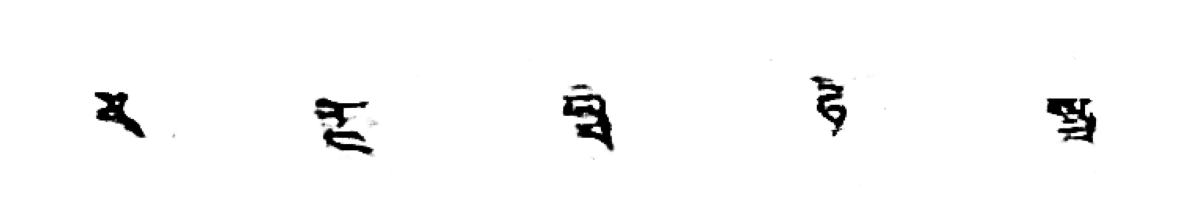

In [10]:
import matplotlib.pyplot as plt

def generate_and_display_images(generator, test_dataset, num_images=5):
    for conditonal_images, _ in test_dataset.take(1): 
        generated_images = generator(conditonal_images, training=False)
        
        plt.figure(figsize=(15, 5))
        for i in range(num_images):
            plt.subplot(1, num_images, i + 1)
            plt.imshow((generated_images[i] + 1) / 2.0, cmap='gray') 
            plt.axis('off')
        plt.show()
        break  

generate_and_display_images(generator, test_dataset)
